# Explore the Tweets of the Game of Thrones Series 7 Finale

More than 2.000.000 Tweets have been recorded during the airing of the GoT finale. This notebook uses these Tweets to recreate the story of the episode.

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import requests
import operator
import nltk
import re

In [2]:
path = 'GoT_finale.csv'

In [3]:
df = pd.read_csv(path, parse_dates=[0])
df['created_at'] = df['created_at'] + pd.Timedelta(hours=2)
df.shape

(2374609, 13)

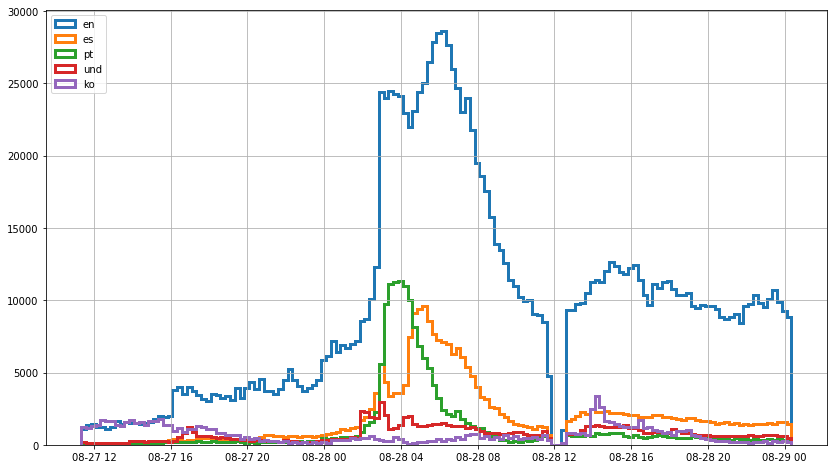

In [4]:
lang = df['lang'].value_counts().index[:5].tolist()
lang_df = df[df['lang'].isin(lang)][['created_at', 'lang']]
delta = lang_df['created_at'].max() - lang_df['created_at'].min()
bins = round((delta.days*24*3600+delta.seconds)/900) #bin pro 15min

plt.figure(figsize=(14,8))
for l in lang:
    lang_df[lang_df['lang']==l]['created_at'].hist(bins=bins, histtype = 'step', linewidth=3, label=l)
plt.legend(loc='upper left')
#plt.yscale('log')
plt.show()

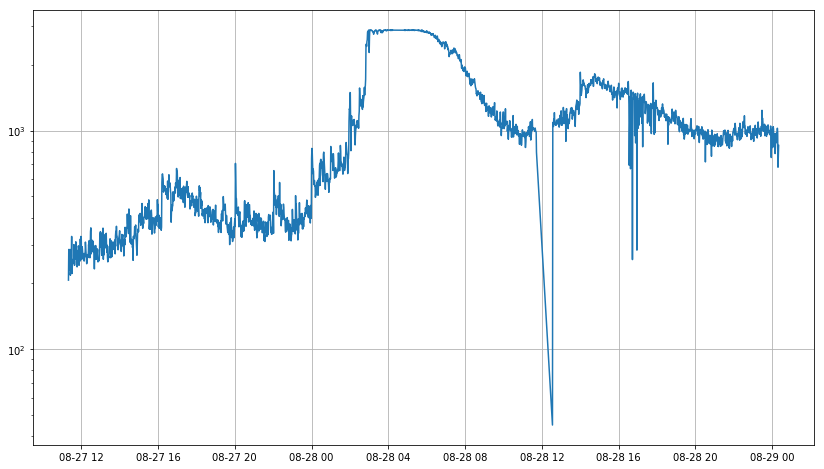

In [5]:
df['created_at']=pd.to_datetime(df['created_at'],format='%y-%d-%m %H:%M:%S')
df.index = df['created_at']

plt.figure(figsize=(14,8))
plt.plot(df['created_at'].groupby([pd.TimeGrouper(freq='min')]).count())
plt.yscale('log')
plt.grid()
plt.show()

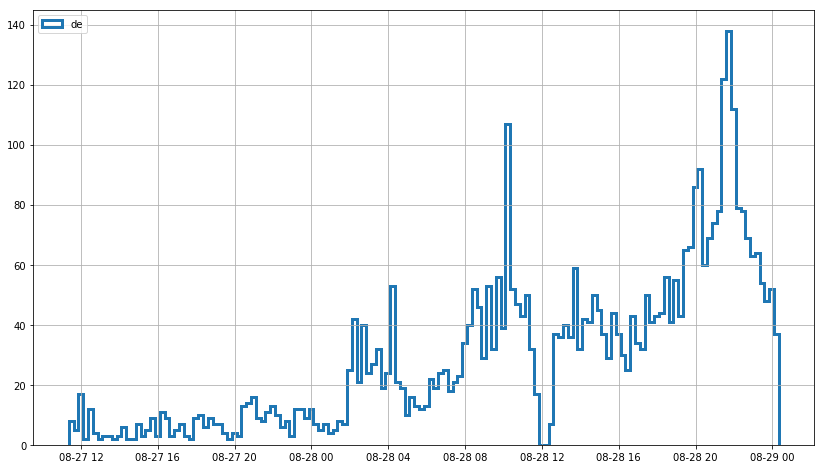

In [6]:
lang = ['de']
lang_df = df[df['lang'].isin(lang)][['created_at', 'lang']]
delta = lang_df['created_at'].max() - lang_df['created_at'].min()
bins = round((delta.days*24*3600+delta.seconds)/900) #bin pro 15min

plt.figure(figsize=(14,8))
for l in lang:
    lang_df[lang_df['lang']==l]['created_at'].hist(bins=bins, histtype = 'step', linewidth=3, label=l)
plt.legend(loc='upper left')
#plt.yscale('log')
plt.show()

In [7]:
print('Tweets\t\t', df.shape[0])

hashtags = {}
pattern = re.compile('#\w+')
for text in tqdm(df['text'].values):
    for hashtag in re.findall(pattern, text):
        if hashtag in hashtags.keys():
            hashtags[hashtag] += 1
        else:
            hashtags[hashtag] = 1
            
df_hash = pd.DataFrame(list(hashtags.items()), columns=['Hashtag', 'Count'])

print('Different #\t', df_hash.shape[0])
df_hash.sort_values(by='Count', ascending=False).head(10).reset_index(drop=True)

  0%|          | 6782/2374609 [00:00<00:34, 67819.26it/s]

Tweets		 2374609


100%|██████████| 2374609/2374609 [00:26<00:00, 89109.64it/s]


Different #	 46436


,Hashtag,Count
0,#GameOfThrones,930131
1,#GameOfThronesFinale,308310
2,#GOT7,259575
3,#GameofThrones,223062
4,#GoTS7,197960
5,#갓세븐,106523
6,#gameofthrones,77310
7,#WinterIsHere,66641
8,#GoT,58172
9,#JB,48003


In [8]:
df['lang'].value_counts()[:10]

en     1418619
es      278524
pt      168654
und     111295
ko      105027
th       94093
fr       45893
it       31577
ar       23883
in       17366
Name: lang, dtype: int64

In [9]:
stop = set(nltk.corpus.stopwords.words())

capitalized = {}
pattern = re.compile("[^#@A-Za-z]([A-Z][a-z]+)")
for tweet, lang in tqdm(df[['text', 'lang']].values):
    words = sorted(set(re.findall(pattern, tweet)))
    for i in itertools.combinations(words, 1):
        if len(stop.intersection([i[0].lower()]))==0:
            key = i[0]+' '+lang
            if key in capitalized.keys():
                capitalized[key] += 1
            else:
                capitalized[key] = 1
capitalized = sorted(capitalized.items(), key=operator.itemgetter(1), reverse=True)

100%|██████████| 2374609/2374609 [01:11<00:00, 32983.05it/s]


In [10]:
url = 'https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters'
html = requests.get(url).text
bs = BeautifulSoup(html, 'lxml')

official_names = []
for liste in bs.findAll('div', {'class':'div-col columns column-width'}):
    for line in liste.findAll('li'):
        official_names.append(line.get_text().split(' as ')[-1].replace('young ', ''))

for table in bs.findAll('table', {'class':'wikitable'}):
    for tr in table.findAll('tr'):
        try:
            official_names.append(tr.findAll('td')[1].get_text())
        except:
            pass
        
name_dict = {name.split(' ')[0]:name for name in official_names}
name_dict.update({' '.join(sorted(name.split(' '))):name for name in official_names})
name_dict.update({'Dany':'Daenerys Targaryen', 'Little':'Petyr Baelish'})

In [11]:
edges = []
lang_count = {lang:df[df['lang']==lang].shape[0] for lang in df['lang'].unique()}
for name, count in capitalized:
    name_1, lang = name.split(' ')
    if name_1 in name_dict.keys():
        if count>500:
            edges.append([name_dict[name_1], count/lang_count[lang], lang])
len(edges)

83

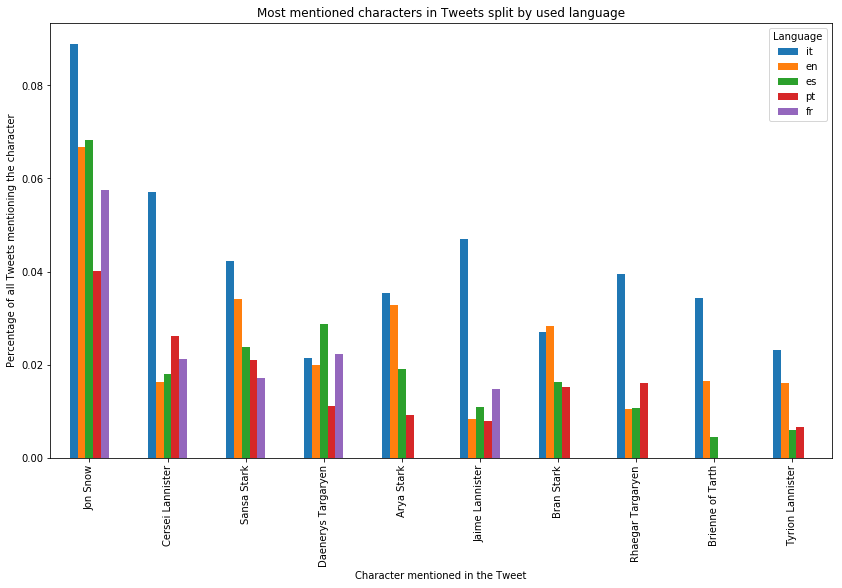

In [12]:
popularity_df = pd.DataFrame(edges, columns=['Name', 'Value', 'Language'])
pivot_df = popularity_df.pivot_table(values='Value', index=popularity_df.Name, columns='Language').fillna(0)

person = pivot_df.sum(axis=1).sort_values(ascending=False).head(10).index
language = pivot_df.loc[person].sum(axis=0).sort_values(ascending=False).head().index

pivot_df.loc[person, language].plot.bar(figsize=(14,8))
plt.title('Most mentioned characters in Tweets split by used language')
plt.xlabel('Character mentioned in the Tweet')
plt.ylabel('Percentage of all Tweets mentioning the character')
plt.show()

# Reconstruct the story with the most tweeting users 

In [13]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def findName(x):
    names = []
    for word in x.split(' '):
        if word.lower() not in stop and word in name_dict.keys():
            names.append(name_dict[word])
    return names

df['names'] = df['text'].apply(lambda x: findName(x))

In [14]:
df.head(2)

,created_at,id,text,source,lang,timestamp_ms,user_id,user_name,user_status,user_follower,user_friends,user_rate,user_created,names
created_at,,,,,,,,,,,,,,
2017-08-27 11:20:11,2017-08-27 11:20:11,901736088514945026,RT @hibiscus0502: 170820 KCON LA @BamBam1A \n지...,"<a href=""http://twitter.com/download/iphone"" r...",ko,1503825611605,796027380187828224,噶布蛋嘴里的寿司,1024,22,109,0.201835,2016-11-08 16:31:31+00:00,[]
2017-08-27 11:20:11,2017-08-27 11:20:11,901736089722826752,HAHAHAHAHHA https://t.co/7aMxPBVBF6,"<a href=""http://twitter.com/download/iphone"" r...",tl,1503825611893,867724962206851072,yas 🐣,976,66,65,1.015385,2017-05-25 12:52:07+00:00,[]


In [15]:
names_df = df[df['names'].astype(str) != '[]'].loc['2017-08-28 03:00:00':'2017-08-28 04:30:00']['names'].to_frame()
time_names = [[time, name] for time, names in names_df.reset_index().values for name in names]
time_df = pd.DataFrame(time_names, columns=['Time', 'Name']).set_index('Time')
time_df.head(2)

,Name
Time,
2017-08-28 03:00:04,Sansa Stark
2017-08-28 03:00:06,Jon Snow


In [16]:
time_names = time_df.assign(Count=1).groupby([pd.TimeGrouper('5s'), 'Name']).count().reset_index().pivot(index='Time', columns='Name', values='Count').fillna(0)
time_names.head(2)

Name,Aeron Greyjoy,Aerys 'The Mad King' Targaryen,Alliser Thorne,Arthur,Arya Stark,Balon Greyjoy,Barristan Selmy,Benjen Stark,Beric Dondarrion,Bianca,...,Tyrion Lannister,Tywin Lannister,Varys,Viserys Targaryen,Walder Frey,Yara Greyjoy,Ygritte,Yohn Royce,Yoren,child Lyanna Stark
Time,,,,,,,,,,,,,,,,,,,,,
2017-08-28 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28 03:00:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


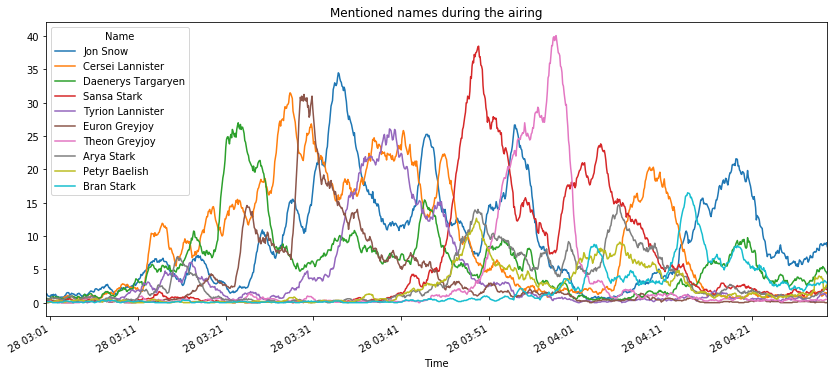

In [17]:
names = time_names.sum(axis=0).sort_values(ascending=False).head(10).index
time_names[names].rolling(12, center=True).mean().dropna().plot(title='Mentioned names during the airing', figsize=(14,6))
plt.show()

In [18]:
time_names[names].corr()

Name,Jon Snow,Cersei Lannister,Daenerys Targaryen,Sansa Stark,Tyrion Lannister,Euron Greyjoy,Theon Greyjoy,Arya Stark,Petyr Baelish,Bran Stark
Name,,,,,,,,,,
Jon Snow,1.000000,0.262423,0.311192,-0.046006,0.397184,0.391635,0.071707,-0.133168,-0.072440,-0.004578
Cersei Lannister,0.262423,1.000000,0.333577,-0.198163,0.529047,0.579247,-0.260762,-0.165307,-0.121887,-0.285538
Daenerys Targaryen,0.311192,0.333577,1.000000,-0.197965,0.197609,0.320070,-0.097012,-0.241955,-0.228043,-0.233682
Sansa Stark,-0.046006,-0.198163,-0.197965,1.000000,-0.117601,-0.222117,0.376850,0.772052,0.785862,0.095482
Tyrion Lannister,0.397184,0.529047,0.197609,-0.117601,1.000000,0.298190,-0.152794,-0.169646,-0.113018,-0.269418
Euron Greyjoy,0.391635,0.579247,0.320070,-0.222117,0.298190,1.000000,-0.125455,-0.280774,-0.230455,-0.283268
Theon Greyjoy,0.071707,-0.260762,-0.097012,0.376850,-0.152794,-0.125455,1.000000,0.340641,0.200847,-0.024866
Arya Stark,-0.133168,-0.165307,-0.241955,0.772052,-0.169646,-0.280774,0.340641,1.000000,0.692408,0.116790
Petyr Baelish,-0.072440,-0.121887,-0.228043,0.785862,-0.113018,-0.230455,0.200847,0.692408,1.000000,0.187895


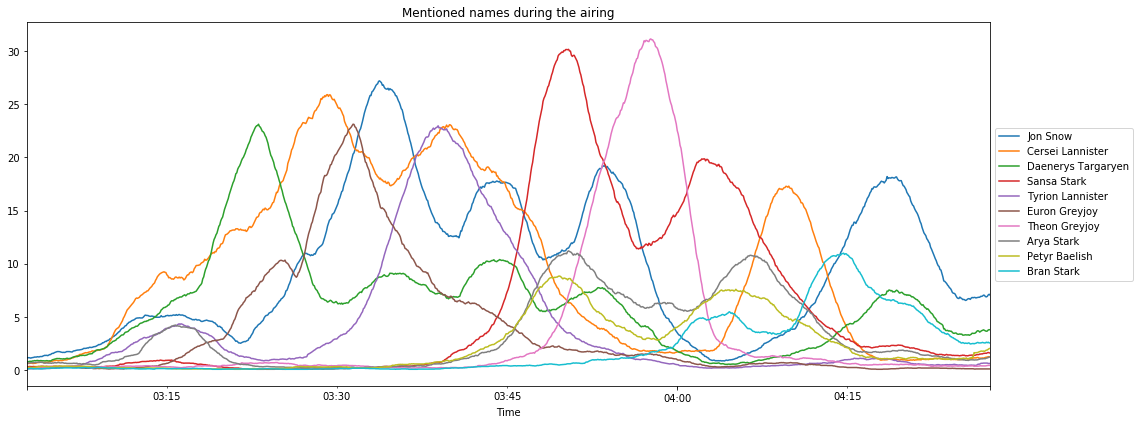

In [19]:
names = time_names.sum(axis=0).sort_values(ascending=False).head(10).index
rolling_df = time_names[names].rolling(60, center=True).mean().dropna()
rolling_df.plot(title='Mentioned names during the airing', figsize=(14,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [20]:
rolling_df.corr()

Name,Jon Snow,Cersei Lannister,Daenerys Targaryen,Sansa Stark,Tyrion Lannister,Euron Greyjoy,Theon Greyjoy,Arya Stark,Petyr Baelish,Bran Stark
Name,,,,,,,,,,
Jon Snow,1.000000,0.367284,0.282279,-0.042464,0.526859,0.542482,0.056065,-0.188774,-0.110233,-0.052688
Cersei Lannister,0.367284,1.000000,0.466993,-0.255791,0.603982,0.778329,-0.352131,-0.247468,-0.179412,-0.380082
Daenerys Targaryen,0.282279,0.466993,1.000000,-0.271252,0.248945,0.448917,-0.160581,-0.370462,-0.361856,-0.370156
Sansa Stark,-0.042464,-0.255791,-0.271252,1.000000,-0.136396,-0.308685,0.522606,0.907145,0.943655,0.106563
Tyrion Lannister,0.526859,0.603982,0.248945,-0.136396,1.000000,0.385315,-0.193896,-0.236564,-0.135034,-0.364802
Euron Greyjoy,0.542482,0.778329,0.448917,-0.308685,0.385315,1.000000,-0.189401,-0.421631,-0.344903,-0.416175
Theon Greyjoy,0.056065,-0.352131,-0.160581,0.522606,-0.193896,-0.189401,1.000000,0.468474,0.351960,-0.025006
Arya Stark,-0.188774,-0.247468,-0.370462,0.907145,-0.236564,-0.421631,0.468474,1.000000,0.932113,0.201296
Petyr Baelish,-0.110233,-0.179412,-0.361856,0.943655,-0.135034,-0.344903,0.351960,0.932113,1.000000,0.263057


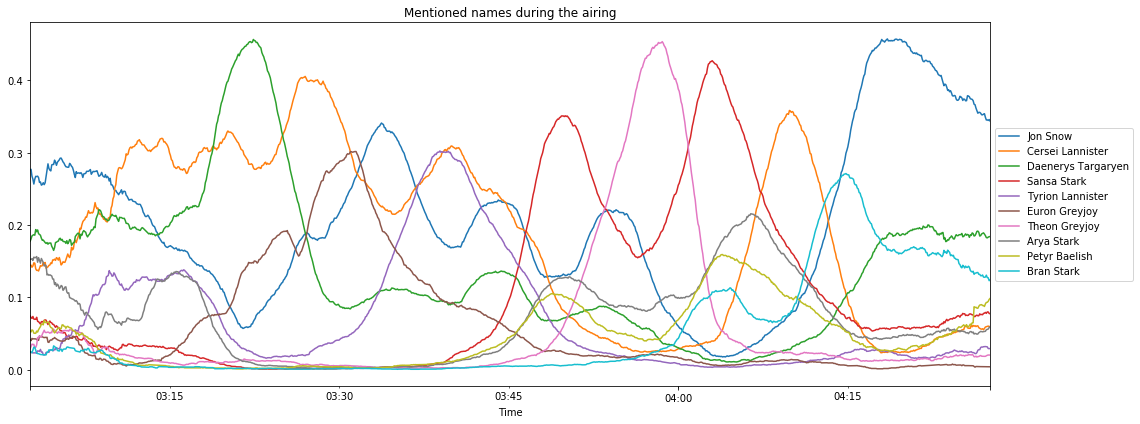

In [21]:
names = time_names.sum(axis=0).sort_values(ascending=False).head(10).index
rolling_df = time_names[names].rolling(60, center=True).mean().dropna()
rolling_df_percent = rolling_df.div(rolling_df.sum(axis=1), axis=0)
rolling_df_percent.plot(title='Mentioned names during the airing', figsize=(14,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [22]:
rolling_df_percent.corr()

Name,Jon Snow,Cersei Lannister,Daenerys Targaryen,Sansa Stark,Tyrion Lannister,Euron Greyjoy,Theon Greyjoy,Arya Stark,Petyr Baelish,Bran Stark
Name,,,,,,,,,,
Jon Snow,1.000000,-0.308065,0.161553,-0.493820,0.090366,-0.035501,-0.267921,-0.442657,-0.379310,0.386900
Cersei Lannister,-0.308065,1.000000,0.309071,-0.542541,0.396622,0.584042,-0.536828,-0.284329,-0.461148,-0.476950
Daenerys Targaryen,0.161553,0.309071,1.000000,-0.621683,0.024688,0.221273,-0.355235,-0.444497,-0.615136,-0.189516
Sansa Stark,-0.493820,-0.542541,-0.621683,1.000000,-0.393954,-0.493046,0.455807,0.716855,0.883445,0.137226
Tyrion Lannister,0.090366,0.396622,0.024688,-0.393954,1.000000,0.200814,-0.319980,-0.399967,-0.448859,-0.439103
Euron Greyjoy,-0.035501,0.584042,0.221273,-0.493046,0.200814,1.000000,-0.268123,-0.644082,-0.558455,-0.479866
Theon Greyjoy,-0.267921,-0.536828,-0.355235,0.455807,-0.319980,-0.268123,1.000000,0.245485,0.217872,-0.094494
Arya Stark,-0.442657,-0.284329,-0.444497,0.716855,-0.399967,-0.644082,0.245485,1.000000,0.786300,0.158076
Petyr Baelish,-0.379310,-0.461148,-0.615136,0.883445,-0.448859,-0.558455,0.217872,0.786300,1.000000,0.357492


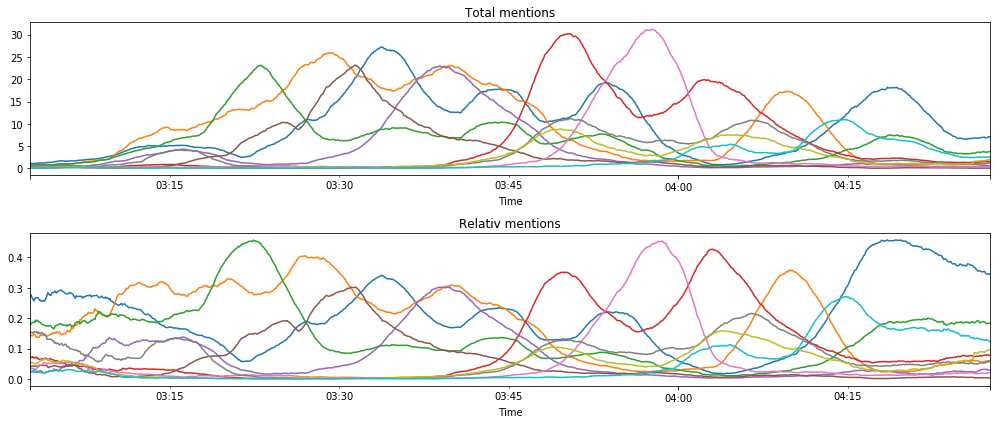

In [23]:
f, axarr = plt.subplots(2)
rolling_df.plot(title='Total mentions', figsize=(14,6), ax=axarr[0], legend=None)
rolling_df_percent.plot(title='Relativ mentions', figsize=(14,6), ax=axarr[1], legend=None)
plt.tight_layout()
plt.show()

In [24]:
df.head()

,created_at,id,text,source,lang,timestamp_ms,user_id,user_name,user_status,user_follower,user_friends,user_rate,user_created,names
created_at,,,,,,,,,,,,,,
2017-08-27 11:20:11,2017-08-27 11:20:11,901736088514945026,RT @hibiscus0502: 170820 KCON LA @BamBam1A \n지...,"<a href=""http://twitter.com/download/iphone"" r...",ko,1503825611605,796027380187828224,噶布蛋嘴里的寿司,1024,22,109,0.201835,2016-11-08 16:31:31+00:00,[]
2017-08-27 11:20:11,2017-08-27 11:20:11,901736089722826752,HAHAHAHAHHA https://t.co/7aMxPBVBF6,"<a href=""http://twitter.com/download/iphone"" r...",tl,1503825611893,867724962206851072,yas 🐣,976,66,65,1.015385,2017-05-25 12:52:07+00:00,[]
2017-08-27 11:20:11,2017-08-27 11:20:11,901736089639165952,RT @KingofNorth_Jon: Jamie opens raven message...,"<a href=""http://twitter.com/download/iphone"" r...",fr,1503825611873,2245343277,Julie.,4141,244,412,0.592233,2013-12-26 20:19:56+00:00,[]
2017-08-27 11:20:12,2017-08-27 11:20:12,901736090981154816,RT @666_dfitt_555: Thank You ❤😭\n\n#갓세븐 #GOT7 ...,"<a href=""http://twitter.com/#!/download/ipad"" ...",en,1503825612193,135510567,skitty💖กานดา,330824,525,380,1.381579,2010-04-21 14:14:03+00:00,[]
2017-08-27 11:20:12,2017-08-27 11:20:12,901736091253825540,RT @502BAMX2: 170114 GOLDEN DISK AWARDS By BAM...,"<a href=""http://twitter.com/download/iphone"" r...",en,1503825612258,712494699819495426,LuThieN55,18444,27,460,0.058696,2016-03-23 04:22:28+00:00,[]


In [25]:
retweets = df[df['text'].str.startswith('RT ')][['lang', 'id']]
retweets.head(2)

,lang,id
created_at,,
2017-08-27 11:20:11,ko,901736088514945026
2017-08-27 11:20:11,fr,901736089639165952


In [26]:
tmp = retweets.groupby([pd.TimeGrouper('min'), 'lang']).count().reset_index().pivot(index='created_at', columns='lang', values='id')
tmp.head(2)

lang,ar,bg,cs,cy,da,de,el,en,es,et,...,sv,ta,th,tl,tr,uk,und,ur,vi,zh
created_at,,,,,,,,,,,,,,,,,,,,,
2017-08-27 11:20:00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0,3.0,NaN,...,NaN,NaN,38.0,1.0,1.0,NaN,8.0,NaN,NaN,NaN
2017-08-27 11:21:00,NaN,NaN,NaN,NaN,NaN,2.0,NaN,72.0,2.0,NaN,...,NaN,NaN,61.0,4.0,NaN,NaN,9.0,NaN,NaN,NaN


In [27]:
cols = tmp.sum(axis=0).sort_values(ascending=False).head().index.tolist()

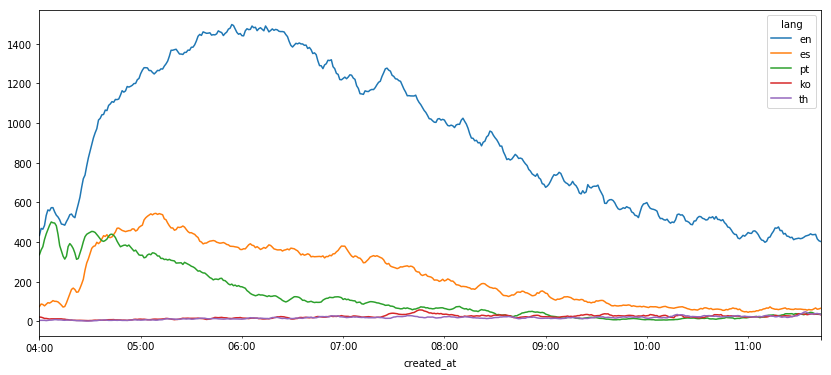

In [28]:
tmp[cols].loc['2017-08-28 04:00:00':'2017-08-28 12:00:00'].rolling(5, center=True, min_periods=1).mean().plot(figsize=(14,6))
plt.show()